✅ Data Loading Complete: adult 3.csv loaded.
First 5 rows of the dataset:
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Fem

C:\Users\karth\AppData\Local\Temp\ipykernel_7544\3923644171.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True) # Mode for categorical



✅ Data Cleaning and Missing Value Imputation Complete.

Dataset Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage

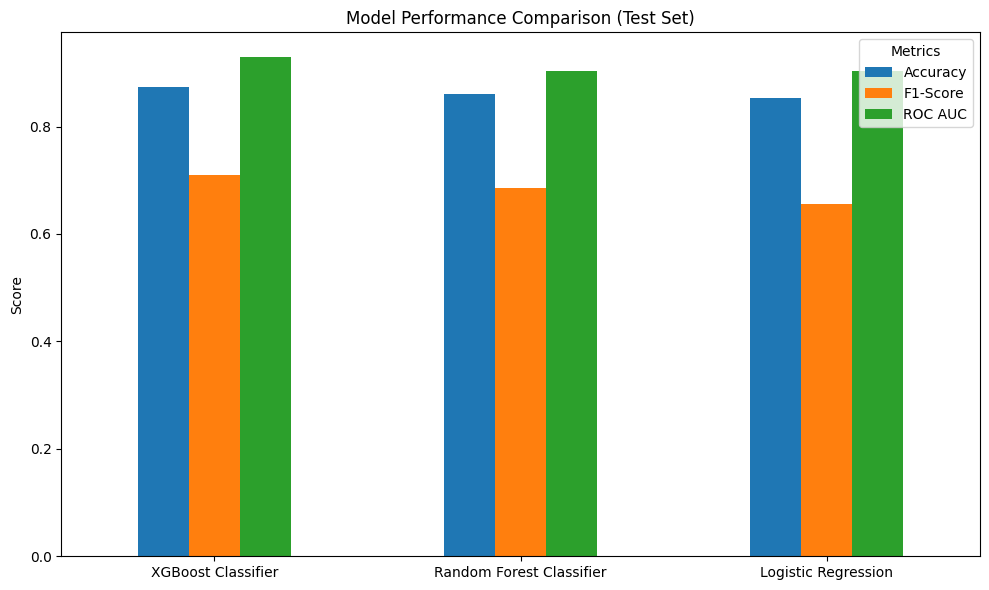

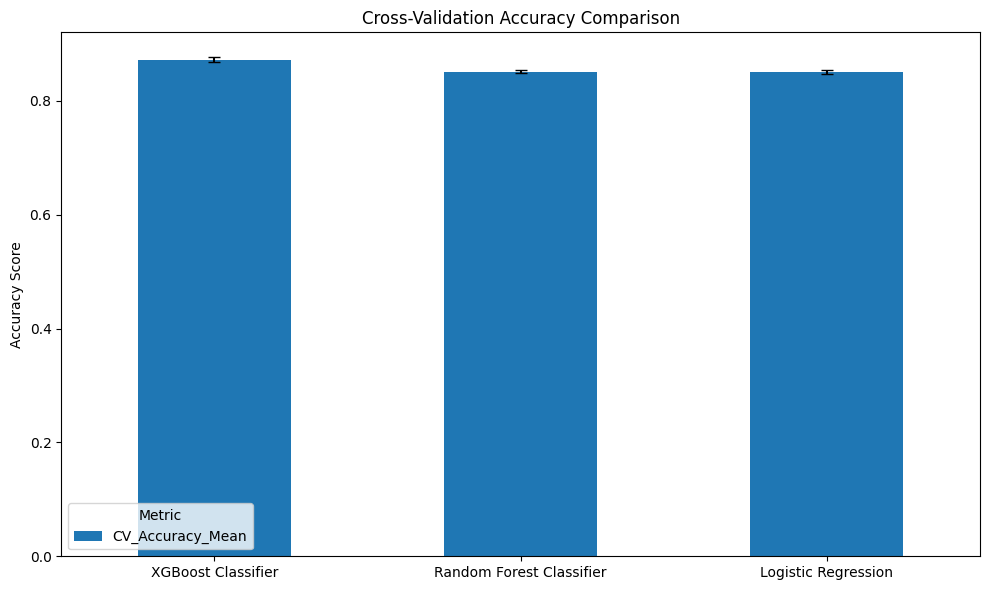


👑 Based on Accuracy Score, the best performing model is: *XGBoost Classifier* with Accuracy = 0.8745

--- ⚙ Hyperparameter Tuning for XGBoost Classifier ---
  Searching for best parameters for XGBoost Classifier...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best hyperparameters found: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Best cross-validation Accuracy: 0.8721

✅ Tuned XGBoost Classifier Test Set Evaluation Results:
    Accuracy: 0.8751
    ROC AUC: 0.9297

--- 🔍 Feature Importance ---
Top 10 Feature Importances:
                              Feature  Importance
32  marital-status_Married-civ-spouse    0.393326
2                     educational-num    0.070743
40         occupation_Exec-managerial    0.046592
3                        capital-gain    0.046484
44           occupation_Other-service    0.036214
4                        capital-loss    0.023497
41         occupation_Farming-fishing    0.020744
0   

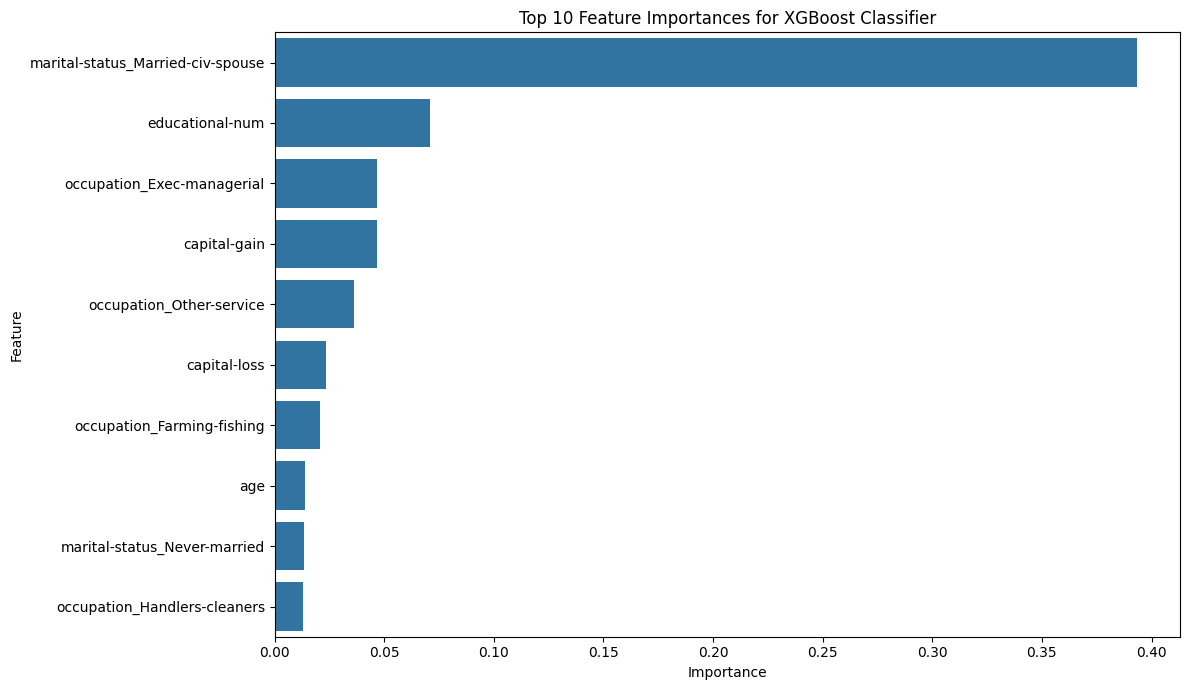


✅ Best model saved as 'xgboost_classifier_income_classifier_model.joblib'


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Suppress specific warnings for cleaner output (optional, but good for final presentation)
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=FutureWarning, module='pandas')

# --- 1. Data Loading ---
try:
    df = pd.read_csv(r"C:\Users\karth\Downloads\adult 3.csv")
    print("✅ Data Loading Complete: adult 3.csv loaded.")
except FileNotFoundError:
    print("Error: 'adult 3.csv' not found. Please ensure the file is in the correct directory.")
    exit()

print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset Info:")
df.info()

# --- 2. Data Cleaning and Initial Preprocessing ---
df.columns = df.columns.str.strip() # Remove leading/trailing spaces from column names

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip() # Remove leading/trailing spaces from string values

df.replace('?', np.nan, inplace=True)

# Impute missing values
for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True) # Mode for categorical

for col in df.select_dtypes(include=['int64', 'float64']).columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True) # Median for numerical

print("\n✅ Data Cleaning and Missing Value Imputation Complete.")
print("\nDataset Info after cleaning:")
df.info()

# --- 3. Separate Features (X) and Target (y) & Split Data ---
X = df.drop('income', axis=1)
y = df['income']

# Address FutureWarning: Ensure y is a 1D array/Series
# .values.ravel() converts a Series/DataFrame column to a 1D numpy array
le = LabelEncoder()
y_encoded = le.fit_transform(y.values.ravel()) # Added .values.ravel() here
print(f"\nIncome classes: {le.classes_}")

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Addressing UserWarning: X does not have valid feature names...
# It's good practice to keep X_train and X_test as DataFrames with column names.
# The pipeline should handle the names correctly if X is a DataFrame.
# If the warning persists, it means the ColumnTransformer is dropping them
# or the model expects numpy arrays directly without names.
# For now, ensure X_train and X_test are passed as DataFrames.

print(f"\n✅ Data split into Training ({len(X_train)} samples) and Testing ({len(X_test)} samples).")
print(f"Training target distribution:\n{pd.Series(y_train).value_counts(normalize=True)}")
print(f"Testing target distribution:\n{pd.Series(y_test).value_counts(normalize=True)}")


# --- 4. Define Preprocessing Steps using ColumnTransformer ---
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist() # Ensure lists for ColumnTransformer
categorical_features = X.select_dtypes(include=['object']).columns.tolist() # Ensure lists for ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough',
    # Ensure ColumnTransformer outputs a DataFrame with feature names (for debugging)
    # This might require scikit-learn >= 0.23 for set_output(transform="pandas")
    # For now, we rely on the pipeline to handle it.
)

print("\n✅ Preprocessing steps defined with ColumnTransformer for adult dataset.")

# --- 5. Create and Evaluate Classification Models with Pipelines and Cross-Validation ---

model_results = {}
all_metrics_df = pd.DataFrame() # To store all detailed metrics for graphing

def train_evaluate_classification_pipeline(name, model_pipeline, X_train, y_train, X_test, y_test, cv_folds=5):
    print(f"\n🚀 Training and Evaluating {name}...")

    print(f"  Performing {cv_folds}-fold Cross-Validation...")
    cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=cv_folds, scoring='accuracy', n_jobs=-1)
    print(f"  CV Accuracy (Mean ± Std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    model_pipeline.fit(X_train, y_train)

    y_pred = model_pipeline.predict(X_test)
    y_prob = model_pipeline.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    print(f"  ✅ {name} Test Set Evaluation Results:")
    print(f"    Accuracy: {accuracy:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall: {recall:.4f}")
    print(f"    F1-Score: {f1:.4f}")
    print(f"    ROC AUC: {roc_auc:.4f}")
    print(f"    Confusion Matrix:\n{cm}")

    # Store results for model comparison graph
    model_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        'CV_Accuracy_Mean': cv_scores.mean(),
        'CV_Accuracy_Std': cv_scores.std()
    }
    return model_pipeline, y_pred

models = {
    "Logistic Regression": Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', LogisticRegression(random_state=42, n_jobs=-1, solver='liblinear'))]),

    "Random Forest Classifier": Pipeline(steps=[('preprocessor', preprocessor),
                                                ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]),

    "XGBoost Classifier": Pipeline(steps=[('preprocessor', preprocessor),
                                          ('classifier', XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                                                                        n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1))])
}

trained_models = {}
predictions = {}

for name, pipeline in models.items():
    trained_pipeline, y_pred = train_evaluate_classification_pipeline(name, pipeline, X_train, y_train, X_test, y_test)
    trained_models[name] = trained_pipeline
    predictions[name] = y_pred

print("\n--- 📊 Summary of Model Performance ---")
results_df = pd.DataFrame(model_results).T
results_df = results_df.sort_values(by='Accuracy', ascending=False)
print(results_df.round(4))

# --- Model Comparison Graphs ---
print("\n--- 📈 Generating Model Comparison Graphs ---")

# Plot 1: Bar chart for Accuracy, F1-Score, and ROC AUC
metrics_to_plot = ['Accuracy', 'F1-Score', 'ROC AUC']
plot_df = results_df[metrics_to_plot]

fig, ax = plt.subplots(figsize=(10, 6))
plot_df.plot(kind='bar', ax=ax, rot=0)
ax.set_title('Model Performance Comparison (Test Set)')
ax.set_ylabel('Score')
ax.legend(title='Metrics')
plt.tight_layout()
plt.show()

# Plot 2: Bar chart for Cross-Validation Accuracy
cv_plot_df = results_df[['CV_Accuracy_Mean']]
fig, ax = plt.subplots(figsize=(10, 6))
cv_plot_df.plot(kind='bar', ax=ax, rot=0, yerr=results_df['CV_Accuracy_Std'], capsize=4) # Include Std Dev as error bars
ax.set_title('Cross-Validation Accuracy Comparison')
ax.set_ylabel('Accuracy Score')
ax.legend(title='Metric')
plt.tight_layout()
plt.show()


best_model_name = results_df.index[0]
best_accuracy_score = results_df.loc[best_model_name, 'Accuracy']

print(f"\n👑 Based on Accuracy Score, the best performing model is: *{best_model_name}* with Accuracy = {best_accuracy_score:.4f}")

# --- 6. Optional: Hyperparameter Tuning for the Best Model ---
print(f"\n--- ⚙ Hyperparameter Tuning for {best_model_name} ---")

param_grid = {}

if best_model_name == "XGBoost Classifier":
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 5]
    }
    tuned_model_pipeline = trained_models[best_model_name]
elif best_model_name == "Random Forest Classifier":
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_features': [0.7, 1.0],
        'classifier__max_depth': [10, None]
    }
    tuned_model_pipeline = trained_models[best_model_name]
else: # Logistic Regression
    print("Logistic Regression typically doesn't require extensive hyperparameter tuning like tree-based models for basic usage.")
    param_grid = {} # No tuning for this example
    best_tuned_model = trained_models[best_model_name] # Assign directly if no tuning

if param_grid:
    print(f"  Searching for best parameters for {best_model_name}...")
    grid_search = GridSearchCV(tuned_model_pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print("\nBest hyperparameters found:", grid_search.best_params_)
    print(f"Best cross-validation Accuracy: {grid_search.best_score_:.4f}")

    best_tuned_model = grid_search.best_estimator_
    y_pred_tuned = best_tuned_model.predict(X_test)
    y_prob_tuned = best_tuned_model.predict_proba(X_test)[:, 1]

    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    roc_auc_tuned = roc_auc_score(y_test, y_prob_tuned)

    print(f"\n✅ Tuned {best_model_name} Test Set Evaluation Results:")
    print(f"    Accuracy: {accuracy_tuned:.4f}")
    print(f"    ROC AUC: {roc_auc_tuned:.4f}")
else:
    print(f"Skipping hyperparameter tuning for {best_model_name} as no param_grid was defined.")


# --- 7. Feature Importance (for Tree-based classifiers) ---
print("\n--- 🔍 Feature Importance ---")
if best_model_name in ["Random Forest Classifier", "XGBoost Classifier"]:
    preprocessor_transformer = best_tuned_model.named_steps['preprocessor']
    
    # Get feature names from OneHotEncoder if it exists
    encoded_feature_names = []
    for name, transformer, features in preprocessor_transformer.transformers_:
        if name == 'cat' and hasattr(transformer, 'get_feature_names_out'):
            try:
                encoded_feature_names = transformer.get_feature_names_out(features)
            except AttributeError:
                # Fallback for older scikit-learn versions if get_feature_names_out isn't available
                print("Warning: get_feature_names_out() not found for OneHotEncoder. Feature names might be generic.")
                pass

    final_feature_names = numerical_features + encoded_feature_names.tolist() # Combine numerical and encoded categorical names

    importances = best_tuned_model.named_steps['classifier'].feature_importances_
    
    # Ensure importances match feature names length
    if len(importances) == len(final_feature_names):
        feature_importances_df = pd.DataFrame({'Feature': final_feature_names, 'Importance': importances})
        feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

        print("Top 10 Feature Importances:")
        print(feature_importances_df.head(10))

        plt.figure(figsize=(12, 7))
        sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(10))
        plt.title(f'Top 10 Feature Importances for {best_model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        print("Could not generate feature importance plot: Mismatch between number of features and importances.")

elif best_model_name == "Logistic Regression":
    print("For Logistic Regression, coefficients indicate feature importance (after scaling).")
    # To get interpretable coefficients for Logistic Regression:
    # You would need to apply the preprocessor to a dummy X and then get feature names.
    # coefs = best_tuned_model.named_steps['classifier'].coef_[0]
    # transformed_features = best_tuned_model.named_steps['preprocessor'].transform(X.head(1))
    # feature_names_out = best_tuned_model.named_steps['preprocessor'].get_feature_names_out()
    # coef_df = pd.DataFrame({'Feature': feature_names_out, 'Coefficient': coefs}).sort_values(by='Coefficient', ascending=False)
    # print(coef_df.head(10))
else:
    print(f"Feature importance is not directly applicable in the same way for {best_model_name}.")


# --- 8. Save the Best Model ---
model_filename = f'{best_model_name.replace(" ", "_").lower()}_income_classifier_model.joblib'
joblib.dump(best_tuned_model, model_filename)
print(f"\n✅ Best model saved as '{model_filename}'")